# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

#### Описание данных : <br>
Данные геологоразведки трёх регионов находятся в трех файлах:
   - geo_data_0 - первый регион;
   - geo_data_1 - второй регион;
   - geo_data_2 - третий регион;

Каждый файл состоит из следующих столбцов:<br>

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).


## Загрузка и подготовка данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [7]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#import phik
#from phik.report import plot_correlation_matrix
#from phik import report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [8]:
# Основные характеристики для расчетов:
BUDGET=10E9         # общий бюджет на разработку
BARREL_PRICE=450000 # стоимость одной тысячи баррелей
TOP_HOLES=200       # количество скважин c максимальным запасом по предсказанию
HOLES=500           # количество скважин для разработки
BOOTSTRAP_SIZE=1000  

In [9]:
try:
    df_1 = pd.read_csv(r'D:\project ML в бизнесе\geo_data_0.csv')
    df_2 = pd.read_csv(r'D:\project ML в бизнесе\geo_data_1.csv')
    df_3 = pd.read_csv(r'D:\project ML в бизнесе\geo_data_2.csv')
except:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')

#### Изучение и подготовка данных для первого региона.

In [10]:
display(df_1.head()), display(df_1.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

(None, None)

Посмотрим основные статистики нашей выборки:

In [11]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Проведем проверку на наличие явных дубликатов: 

In [13]:
df_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [14]:
df_1['new'] = df_1['f0']* 100

In [15]:
df_1.head()

,id,f0,f1,f2,product,new
0,txEyH,0.705745,-0.497823,1.221170,105.280062,70.574498
1,2acmU,1.334711,-0.340164,4.365080,73.037750,133.471129
2,409Wp,1.022732,0.151990,1.419926,85.265647,102.273226
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,-3.217162
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,198.843106


In [7]:
df_1.duplicated().sum()

0

In [8]:
df_1[['f0','f1','f2','product']].corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [9]:
df_1[['f0','f1','f2','product']].phik_matrix()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


,f0,f1,f2,product
f0,1.000000,0.762170,0.000000,0.215525
f1,0.762170,1.000000,0.000000,0.253544
f2,0.000000,0.000000,1.000000,0.475901
product,0.215525,0.253544,0.475901,1.000000


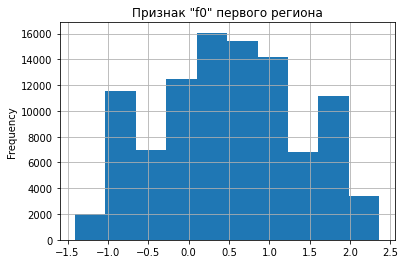

In [10]:
df_1['f0'].plot(kind='hist',grid=True,title='Признак "f0" первого региона');

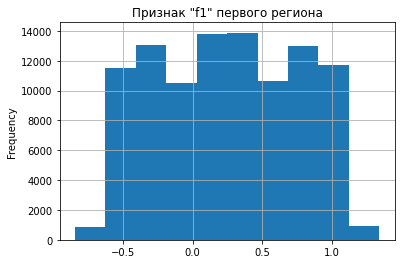

In [11]:
df_1['f1'].plot(kind='hist',grid=True,title='Признак "f1" первого региона');

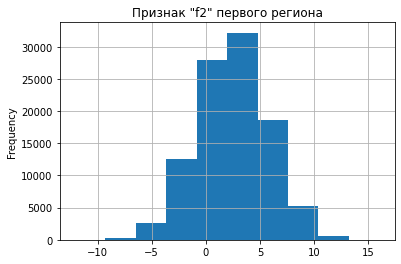

In [12]:
df_1['f2'].plot(kind='hist',grid=True,title='Признак "f2" первого региона');

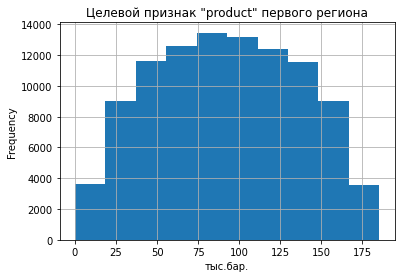

In [13]:
df_1['product'].plot(kind='hist',grid=True,title='Целевой признак "product" первого региона');
plt.xlabel('тыс.бар.');

### Подготовка данных для второго региона.

In [14]:
display(df_2.head()), display(df_2.info())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

(None, None)

Посмотрим основные статистики нашей выборки:

In [15]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Проведем проверку на наличие явных дубликатов: 

In [16]:
df_2.duplicated().sum()

0

In [17]:
df_2[['f0','f1','f2','product']].corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [18]:
df_2[['f0','f1','f2','product']].phik_matrix()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


,f0,f1,f2,product
f0,1.000000,0.196080,0.000000,0.628482
f1,0.196080,1.000000,0.000000,0.185965
f2,0.000000,0.000000,1.000000,0.978936
product,0.628482,0.185965,0.978936,1.000000


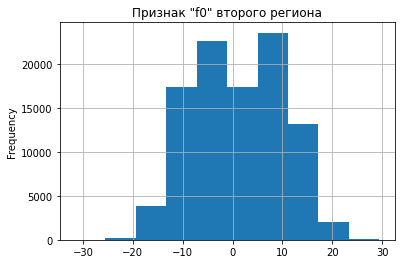

In [19]:
df_2['f0'].plot(kind='hist',grid=True,title='Признак "f0" второго региона');

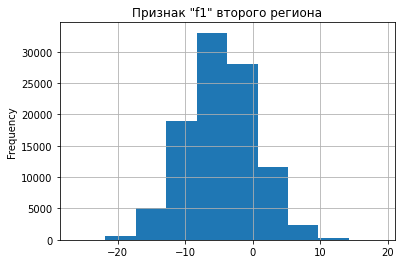

In [20]:
df_2['f1'].plot(kind='hist',grid=True,title='Признак "f1" второго региона');

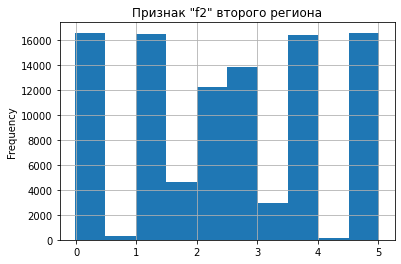

In [21]:
df_2['f2'].plot(kind='hist',grid=True,title='Признак "f2" второго региона');

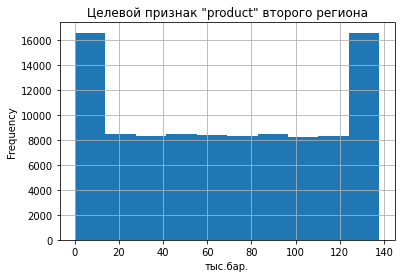

In [22]:
df_2['product'].plot(kind='hist',grid=True,title='Целевой признак "product" второго региона');
plt.xlabel('тыс.бар.');

### Подготовка данных для третьего региона.

In [23]:
display(df_3.head()), display(df_3.info())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

(None, None)

Посмотрим основные статистики нашей выборки:

In [24]:
df_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Проведем проверку на наличие явных дубликатов: 

In [25]:
df_3.duplicated().sum()

0

In [26]:
df_3[['f0','f1','f2','product']].corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [27]:
df_3[['f0','f1','f2','product']].phik_matrix()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


,f0,f1,f2,product
f0,1.000000,0.000000,0.000000,0.201068
f1,0.000000,1.000000,0.000000,0.221022
f2,0.000000,0.000000,1.000000,0.443287
product,0.201068,0.221022,0.443287,1.000000


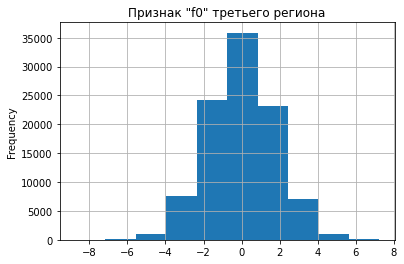

In [28]:
df_3['f0'].plot(kind='hist',grid=True,title='Признак "f0" третьего региона');

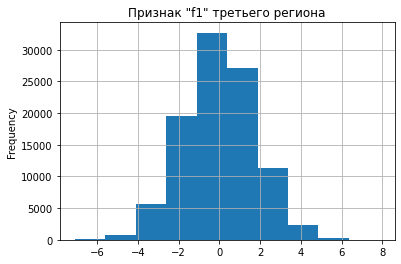

In [29]:
df_3['f1'].plot(kind='hist',grid=True,title='Признак "f1" третьего региона');

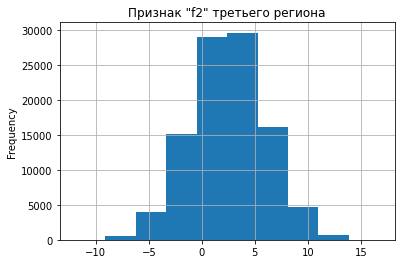

In [30]:
df_3['f2'].plot(kind='hist',grid=True,title='Признак "f2" третьего региона');

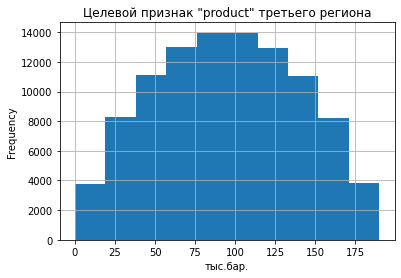

In [31]:
df_3['product'].plot(kind='hist',grid=True,title='Целевой признак "product" третьего региона');
plt.xlabel('тыс.бар.');

## Обучение и проверка модели

In [32]:
def modeling(df):
    
    # выделяем целевой признак и признаки для прогноза
    X=df.drop(['id','product'], axis=1)
    y=df['product']
    
    # делим выборку на тренировочную и валидационную выборки в соотношении 75:25
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # обучаем модель линейной регрессии
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    mse = mean_squared_error(pred, y_valid)
    rmse = np.sqrt(mse)
    mean_values=pred.mean()
    return y_valid, pred, mse, rmse, mean_values

#### Первый регион.

In [33]:
y_valid_1, pred_1, mse_1, rmse_1, mean_values_1 = modeling(df_1)

In [34]:
print('RMSE_1:', rmse_1)
print('Средний запас предсказанного сырья:', mean_values_1,'тыс.бар.')

RMSE_1: 37.75660035026169
Средний запас предсказанного сырья: 92.39879990657768 тыс.бар.


#### Второй регион.

In [35]:
y_valid_2, pred_2, mse_2, rmse_2, mean_values_2 = modeling(df_2)

In [36]:
print('RMSE_2:', rmse_2)
print('Средний запас предсказанного сырья:', mean_values_2,'тыс.бар.')

RMSE_2: 0.890280100102884
Средний запас предсказанного сырья: 68.71287803913762 тыс.бар.


#### Третий регион.

In [37]:
y_valid_3, pred_3, mse_3, rmse_3, mean_values_3 = modeling(df_3)

In [38]:
print('RMSE_3:', rmse_3)
print('Средний запас предсказанного сырья:', mean_values_3,'тыс.бар.')

RMSE_3: 40.145872311342174
Средний запас предсказанного сырья: 94.77102387765939 тыс.бар.


Средний запас сырья по предсказанным данным больше у третьего региона, но среднеквадратическая ошибка здесь так же самая большаяя.

## Подготовка к расчёту прибыли

#### Функция для расчета прибыли.

In [39]:
min_price=np.round(BUDGET/(BARREL_PRICE*TOP_HOLES)) 
print(min_price,'тыс.бар.')

111.0 тыс.бар.


- Достаточный объём сырья для безубыточной разработки новой скважины= 111 тыс.баррелей

#### Сравним средним запас по предсказаниям модели в каждом регионе  с достаточным объёмом сырья для безубыточной разработки новой скважины.

In [40]:
print('Достаточный объём:', min_price,'тыс.бар.')
print('Первый регион:', np.round(y_valid_1.mean(),decimals=2),'тыс.бар.')
print('Второй регион:', np.round(y_valid_2.mean(),decimals=2),'тыс.бар.')
print('Третий регион:', np.round(y_valid_3.mean(),decimals=2),'тыс.бар.')

Достаточный объём: 111.0 тыс.бар.
Первый регион: 92.33 тыс.бар.
Второй регион: 68.73 тыс.бар.
Третий регион: 95.15 тыс.бар.


- Во всех регионах средний запас сырья по предсказаниям модели меньше достаточного объёма сырья для безубыточной разработки новой скважины.

## Расчёт прибыли и рисков 

Подготовка типов данных:

In [41]:
def type_series(y, pred):
    y=y.reset_index(drop=True)
    pred=pd.Series(pred)
    return y, pred

In [42]:
y_valid_1, pred_1=type_series(y_valid_1, pred_1)

In [43]:
y_valid_2, pred_2=type_series(y_valid_2, pred_2)

In [44]:
y_valid_3, pred_3=type_series(y_valid_3, pred_3)

#### Посчитаем прибыль по выбранным скважинам и предсказаниям модели.

In [45]:
#функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def profit(y: pd.Series, pred: pd.Series)-> int:
    pred_top = pred.sort_values(ascending = False)
    selected = y[pred_top.index][:TOP_HOLES]
    value = selected.sum()
    profit = value*BARREL_PRICE-BUDGET 
    return profit

Первый регион

In [46]:
print(np.round(profit(y_valid_1, pred_1)/1000000,decimals=2),',млн.руб.')

3359.14 ,млн.руб.


Второй регион

In [47]:
print(np.round(profit(y_valid_2, pred_2)/1000000,decimals=2),',млн.руб.')

2415.09 ,млн.руб.


Третий регион

In [48]:
print(np.round(profit(y_valid_3, pred_3)/1000000,decimals=2),',млн.руб.')

2598.57 ,млн.руб.


#### Применим технику Bootstrap c 1000 выборок, чтобы найти распределение прибыли. Также найдем среднюю прибыль, 95%-ый доверительный интервал и риск убытков.

In [49]:
def bootstrap(y_valid: pd.Series , pred: pd.Series):
    state = np.random.RandomState(12345)
    values_profit = []
    for i in range(BOOTSTRAP_SIZE):
        y_subsample = y_valid.sample(n = HOLES, replace = True, random_state=state)
        pred_subsumple = pred[y_subsample.index]
        pred_subsumple = pred_subsumple.reset_index(drop = True)
        y_subsample = y_subsample.reset_index(drop = True)
        profit_dist = profit(y_subsample, pred_subsumple)
        values_profit.append(profit_dist/1000000)
    values_profit = pd.Series(values_profit)    
    profit_mean = np.round(values_profit.mean(),decimals=2),
    lower = np.round(values_profit.quantile(0.25),decimals=2),
    higher = np.round(values_profit.quantile(0.975),decimals=2),
    risk = ((values_profit < 0).mean())*100
    return values_profit, profit_mean, lower, higher, risk

#### Первый регион

In [50]:
values_profit_1, profit_mean_1, lower_1, higher_1, risk_1 = bootstrap(y_valid_1,pred_1)

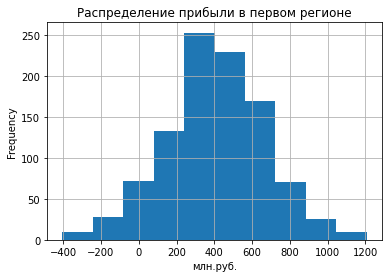

In [51]:
values_profit_1.plot(kind='hist',title='Распределение прибыли в первом регионе',grid=True);
plt.xlabel('млн.руб.');

#### Второй регион

In [52]:
values_profit_2, profit_mean_2, lower_2, higher_2, risk_2 = bootstrap(y_valid_2,pred_2)

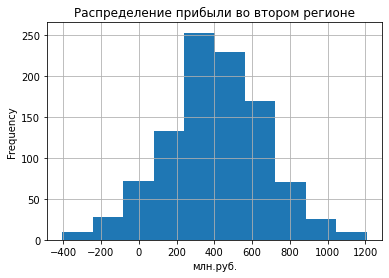

In [53]:
values_profit_1.plot(kind='hist',title='Распределение прибыли во втором регионе',grid=True);
plt.xlabel('млн.руб.');

#### Третий регион

In [54]:
values_profit_3, profit_mean_3, lower_3, higher_3, risk_3 = bootstrap(y_valid_3,pred_3)

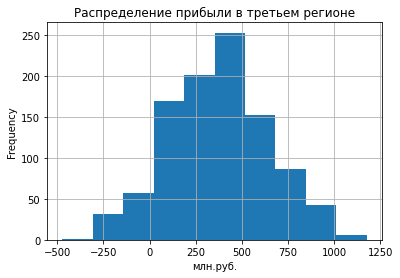

In [55]:
values_profit_3.plot(kind='hist',title='Распределение прибыли в третьем регионе',grid=True);
plt.xlabel('млн.руб.');

In [56]:
final=pd.DataFrame(
                  [
                   [profit_mean_1, lower_1, higher_1, risk_1],
                   [profit_mean_2, lower_2, higher_2, risk_2],
                   [profit_mean_3, lower_3, higher_3, risk_3]],
                   index=['Первый регион','Второй регион','Третий регион'],
                   columns=['Средняя прибыль,млн.руб','Нижняя граница доверительно интервала,млн.руб.',
                            'Верхний граница доверительно интервала,млн.руб.','Риск убытков,%'
                                                                                                        ]
                                                                                                        )

In [57]:
display(final)

,"Средняя прибыль,млн.руб","Нижняя граница доверительно интервала,млн.руб.","Верхний граница доверительно интервала,млн.руб.","Риск убытков,%"
Первый регион,"(406.28,)","(245.81,)","(911.74,)",6.7
Второй регион,"(432.62,)","(299.19,)","(815.97,)",1.9
Третий регион,"(377.36,)","(183.72,)","(901.77,)",7.4


### Вывод:<br>
В рамках данного исследования была проведена подготовка данных, обучена модель линейной регрессии и сделан прогноз запасов для скважин из трёх регионов:<br> 
* Регион 1. Средний запас сырья: 92.33 тыс. баррелей*   
* Регион 2. Средний запас сырья: 68.73 тыс. баррелей*  
* Регион 3. Средний запас сырья: 95.15 тыс. баррелей*  
Достаточный объём: 1111.0

Достаточный объём сырья для безубыточной разработки - новой скважины равен 111 тыс. барреля.

В каждом из трёх регионов средний запас сырья скважины меньше полученного значения достаточного объёма сырья.

#### Прибыль по выбранным скважинам и предсказаниям модели. <br>

 - Регион 1- 3359,14 ,млн.руб.
 - Регион 2- 2415 ,млн.руб. 
 - Реuион 3- 2598,57 ,млн.руб.

#### Применили технику Bootstrap с 1000 выборок, для нахождения распределение прибыли. <br>

In [58]:
display(final)

,"Средняя прибыль,млн.руб","Нижняя граница доверительно интервала,млн.руб.","Верхний граница доверительно интервала,млн.руб.","Риск убытков,%"
Первый регион,"(406.28,)","(245.81,)","(911.74,)",6.7
Второй регион,"(432.62,)","(299.19,)","(815.97,)",1.9
Третий регион,"(377.36,)","(183.72,)","(901.77,)",7.4


На основании полученных данных можно сделать вывод, что регион 2 является наиболее привлекательным для разработки. Самая высокая прибыль лучших месторождений и наименьший риск получения убытков..  

Данный регион рекомендован к освоению.  